# Bike sharing linear regression

## Exercise - Load train/test sets & remove collinear features

> **Exercise**: Load the train/test sets into the `X_tr`, `y_tr`, `X_te` and `y_te` variables. Remove features that make the `X_tr` matrix, with the additional column of ones, rank deficient. Also, you might want to remove nearly collinear features if they hurt performance.

**Self-assessment**: Verify that the `X_tr` matrix with the additional column of ones has full rank. Compute its condition number.

In [89]:
import pandas as pd
from scipy.linalg import lstsq
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor

In [20]:
# Extract X/y Numpy variables
data_tr = pd.read_csv('data/bike-sharing-train.csv')
data_te = pd.read_csv('data/bike-sharing-test.csv')

X_tr = data_tr.drop('casual', axis=1).values
y_tr = data_tr.casual.values

X_te = data_te.drop('casual', axis=1).values
y_te = data_te.casual.values

data_tr.head()

,temp,temp_C,hum,windspeed,atemp,atemp_C,yr,workingday,holiday,casual
0,0.368,9.296,0.569,0.148,0.379,9.014,1,1,0,1603
1,0.700,24.900,0.761,0.084,0.660,27.560,0,1,0,768
2,0.282,5.254,0.538,0.187,0.282,2.612,0,0,0,424
3,0.335,7.745,0.450,0.308,0.320,5.120,0,1,0,231
4,0.398,10.706,0.466,0.290,0.388,9.608,1,1,0,663


In [64]:
# Verify that X_tr with the additional column of ones has full rank

### we remove all collinear and nearly collinear features
### namely temp_C, and atemp_C
X1_tr = np.c_[np.ones(X_tr.shape[0]), X_tr]
X1_tr = np.delete(X1_tr, [2, 6], axis=1)
rk = np.linalg.matrix_rank(X1_tr)


X1_te = np.c_[np.ones(X_te.shape[0]), X_te]
X1_te = np.delete(X1_te, [2, 6], axis=1)

# Compute its condition number
cn=np.linalg.cond(X1_tr)

print('Number of features of X1: {}'.format(X1_tr.shape[1]))
print('Rank of X1: {}'.format(rk))
print('Ill-conditioning of X1: {}'.format(cn))

Number of features of X1: 8
Rank of X1: 8
Ill-conditioning of X1: 84.96199383767939


## Exercise - Fit a linear regression model

> **Exercise**: (A) Fit a linear regression model to the `X_tr`, `y_tr` variables. Evaluate its performance on the test set using the mean absolute error (MAE). (B) Also, try fitting a linear regression with the Huber loss. (C) Pick one feature (e.g., temperatures) and plot the predictions from your best model (e.g., temperature vs. casual users plot).

**Note**: Your models might predict a negative number of users. In this case, you might want to set a lower limit with the Numpy `maximum()` function to improve performance, e.g. `y_pred = np.maximum(y_pred, 50)`.

In [56]:
# Compare models with mean absolute error (MAE)
def MAE(y, y_pred):
    return np.mean(np.abs(y-y_pred))

In [65]:
# (A) Fit and evaluate a linear regression model
lr = LinearRegression()
lr.fit(X1_tr, y_tr)

y_pred_lr = lr.predict(X1_te)
mae_lr = MAE(y_te, y_pred_lr)

# (B) Same with Huber loss
huber = HuberRegressor(epsilon=1.35)
huber.fit(X1_tr, y_tr)
y_pred_hbr = huber.predict(X1_te)
mae_hbr = MAE(y_te, y_pred_hbr)

print('MAE LR: {:2F}'.format(mae_lr))
print('MAE Huber: {:2F}'.format(mae_hbr))

MAE LR: 288.412131
MAE Huber: 278.165083


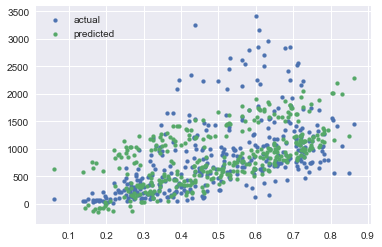

In [74]:
# (C) Plot best model
sns.set()
plt.scatter(X1_te[:, 1], y_te, label='actual', s=15)
plt.scatter(X1_te[:, 1], y_pred_hbr, label='predicted', s=15)
plt.legend(loc='upper left')
plt.show()

## Exercise - Separate sources and fit two linear regressions

We saw in the course that we can identify two sources in the data.

1. Data points collected during working days
1. Data points collected during non-working days

The goal of this exercise is to create a model for each source and see whether this improves performance.

> **Exercise**: Create a model for each source and evaluate the overall performance on the test set using MAE. Compare your models to a baseline using a bar chart.

In [87]:
# Separate data points from the two sources
mask_tr= data_tr.workingday == 0
mask_te= data_te.workingday == 0

X1_tr_wkday = X1_tr[mask_tr]
y_tr_wkday = y_tr[mask_tr]

X1_tr_notwkday = X1_tr[~mask_tr]
y_tr_notwkday = y_tr[~mask_tr]


X1_te_wkday = X1_te[mask_te]
y_te_wkday = y_te[mask_te]

X1_te_notwkday = X1_te[~mask_te]
y_te_notwkday = y_te[~mask_te]

# Create a model for each one
lr_wkday = LinearRegression()
lr_notwkday= LinearRegression()

lr_wkday.fit(X1_tr_wkday, y_tr_wkday)
lr_notwkday.fit(X1_tr_notwkday, y_tr_notwkday)

# Evaluate the overall performance using MAE
y_pred_notwkday = lr_notwkday.predict(X1_te_notwkday)
y_pred_wkday = lr_wkday.predict(X1_te_wkday)

mae_wkday = MAE(y_te_wkday, y_pred_wkday)
mae_notwkday = MAE(y_te_notwkday, y_pred_notwkday)

print('MAE WKDAY: {:2F}'.format(mae_wkday))
print('MAE NOT WKDAY: {:2F}'.format(mae_notwkday))

MAE WKDAY: 409.837720
MAE NOT WKDAY: 162.491443


In [109]:
# Compare your models to a baseline using a bar chart
dummy = DummyRegressor(strategy='median')
dummy.fit(X1_tr, y_tr)
pred_baseline = dummy.predict(X1_te)

mae_baseline = MAE(y_te, pred_baseline)

print('MAE BASELINE: {:2F}'.format(mae_baseline))

MAE BASELINE: 503.573770


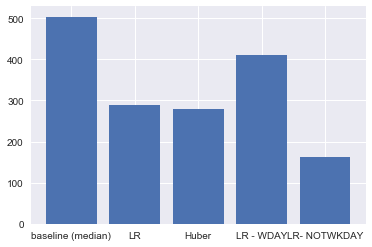

In [110]:
plt.bar([1, 2, 3, 4, 5], [mae_baseline, mae_lr, mae_hbr, mae_wkday, mae_notwkday])
plt.xticks([1, 2, 3, 4, 5], ['baseline (median)', 'LR', 'Huber', 'LR - WDAY', 'LR- NOTWKDAY'])
plt.show()

## Exercise - R^2 coefficient

> **Exercise**: Compute the $R^{2}$ coefficient of your different models on the test set.

In [111]:
print('R2 Dummy : {:2F}'.format(dummy.score(X1_te, y_te)))
print('R2 LR : {:2F}'.format(lr.score(X1_te, y_te)))
print('R2 Huber : {:2F}'.format(huber.score(X1_te, y_te)))
print('R2 LR - NOTWKDAY : {:2F}'.format(lr_notwkday.score(X1_te_notwkday, y_te_notwkday)))
print('R2 LR - WKDAY : {:2F}'.format(lr_wkday.score(X1_te_wkday, y_te_wkday)))


R2 Dummy : -0.052219
R2 LR : 0.668095
R2 Huber : 0.664928
R2 LR - NOTWKDAY : 0.695213
R2 LR - WKDAY : 0.627522
